In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
from cv2 import dnn_superres
from google.colab.patches import cv2_imshow
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

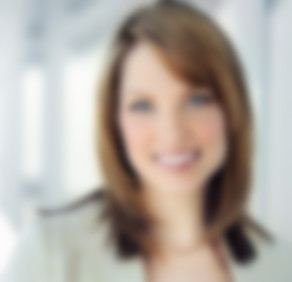

In [21]:
# Declaring Constants
IMAGE_PATH = "/content/drive/My Drive/Domain Adaptation/Del/HD/Final/front_face.jpg"
SAVED_MODEL_PATH_ESRGAN = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
SAVED_MODEL_PATH_EDSR = "/content/drive/My Drive/Domain Adaptation/Del/HD/EDSR_x3.pb"

# Load the image
image = cv2.imread(IMAGE_PATH)
cv2_imshow(image)

##Preprocessing

In [22]:
def balance_colors(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_balanced = clahe.apply(l)

    # Merge LAB channels
    balanced_lab = cv2.merge((l_balanced, a, b))

    # Convert back to BGR color space
    balanced_image = cv2.cvtColor(balanced_lab, cv2.COLOR_LAB2BGR)

    return balanced_image

def detect_edges(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 10, 50)

    return edges

def equalize_image(image):
    # Convert image to grayscale if it's in color
    if len(image.shape) == 3:
        # Split image into RGB channels
        r, g, b = cv2.split(image)

        # Apply histogram equalization to each channel
        r_eq = cv2.equalizeHist(r)
        g_eq = cv2.equalizeHist(g)
        b_eq = cv2.equalizeHist(b)

        # Merge the equalized channels back into an RGB image
        equalized_image = cv2.merge((r_eq, g_eq, b_eq))
    else:
        # If the image is already grayscale, apply histogram equalization directly
        equalized_image = cv2.equalizeHist(image)

    return equalized_image


# Function to perform Anisotropic Diffusion on a single image
def anisotropic_diffusion(image, iterations=10, kappa=100, gamma=0.02, delta_t=0.1):

    # Apply Canny edge detection to compute gradients
    edges = cv2.Canny(image, 50, 150)

    # Invert the edges to get a binary mask for non-edge regions
    edges = 255 - edges

    # Apply diffusion separately to each color channel
    enhanced_image = np.zeros_like(image)
    for i in range(3):
        enhanced_image[:, :, i] = anisotropic_diffusion_single_channel(image[:, :, i], edges, iterations, kappa, gamma, delta_t)

    return enhanced_image

# Function to apply Anisotropic Diffusion to a single-channel image
def anisotropic_diffusion_single_channel(image, edges, iterations=1, kappa=5, gamma=0.02, delta_t=0.1):

    # Convert image to float64
    image = image.astype(np.float64)

    for _ in range(iterations):
        # Calculate gradients using Laplacian filter
        gradient = cv2.Laplacian(image, cv2.CV_64F)

        # Modify the conductance function based on the edges mask
        c = 1 / (1 + edges / kappa)

        # Update image
        image += delta_t * gradient * c

    # Clip values to ensure they are within the range [0, 255] and convert back to uint8
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

# Function to process input image and save output image
def process_image(image):

    # Perform image enhancement using Anisotropic Diffusion
    enhanced_image = anisotropic_diffusion(image)

    return enhanced_image


In [23]:
# Balance colors
balanced_image = balance_colors(image)

equalized_image = equalize_image(image)

Anisotropicdiffused_image = process_image(image)

##Super Resolution Models


In [24]:
def upscale_image_EDSR(image):
    # Create an SR object
    sr = dnn_superres.DnnSuperResImpl_create()

    # Read the EDSR model
    sr.readModel(SAVED_MODEL_PATH_EDSR)

    # Set the desired model and scale
    sr.setModel("edsr", 3)

    # Upscale the image using EDSR
    upscaled_image = sr.upsample(image)

    return upscaled_image

def upscale_image_ESRGAN(image, model_path = SAVED_MODEL_PATH_ESRGAN):
    """
    Upscales an image using the ESRGAN model.

    Args:
        image: Input image data (numpy array)
        model_path: Path to the saved ESRGAN model
        output_path: Path to save the upscaled output image

    Returns:
        The upscaled image (numpy array)
    """
    # Convert the image to uint8 if it's not already in this format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Convert the image to BGR format if it's RGB
    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    hr_image = tf.convert_to_tensor(image)

    # If PNG, remove the alpha channel. The model only supports images with 3 color channels.
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[..., :-1]

    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.expand_dims(hr_image, 0)

    # Plotting Original Resolution image
    plot_image(tf.squeeze(hr_image), title="Original Image")
    save_image(tf.squeeze(hr_image), filename="Original Image")

    # Load the model
    model = hub.load(model_path)

    start = time.time()
    # Cast the input tensor to float32
    hr_image_float = tf.cast(hr_image, tf.float32)
    fake_image = model(hr_image_float)
    fake_image = tf.squeeze(fake_image)
    print(f"Time Taken: {time.time() - start:.2f} seconds")

    # Plotting Super Resolution Image
    plot_image(tf.squeeze(fake_image), title="Super Resolution")

    # Save the output image in the same format as the input
    if image.ndim == 3 and image.shape[2] == 3:
        output_image = cv2.cvtColor(fake_image.numpy(), cv2.COLOR_BGR2RGB)
    else:
        output_image = fake_image.numpy()

    return output_image

def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
        image: 3D image tensor. [height, width, channels]
        filename: Name of the file to save.
    """
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(image.numpy().astype(np.uint8))
    image.save(f"{filename}.jpg")
    print(f"Saved as {filename}.jpg")



def plot_image(image, title=""):
    """
    Plots images from image tensors.
    Args:
        image: 3D image tensor. [height, width, channels].
        title: Title to display in the plot.
    """
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(image.numpy().astype(np.uint8))
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

##Post Processing

In [25]:
def blend_images(image1, image2, alpha):
    """
    Blends two images with a given alpha value.

    Args:
        image1: The first input image (numpy array)
        image2: The second input image (numpy array)
        alpha: The blending factor (between 0 and 1)

    Returns:
        The blended image (numpy array)
    """
    # Convert the images to float32 for blending
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Resize the images to the same size
    height, width = image1.shape[:2]
    resized_image1 = cv2.resize(image1, (width, height))
    resized_image2 = cv2.resize(image2, (width, height))

    # Blend the resized images
    blended_image = cv2.addWeighted(resized_image1, alpha, resized_image2, 1 - alpha, 0)

    # Convert the blended image back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image


##Image Enhancement

Saved as Original Image.jpg
Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

Time Taken: 3.92 seconds


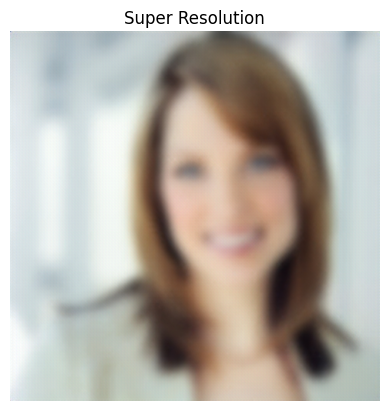

In [26]:
resized_image = cv2.resize(image, (120, 120))

upscaled_image_edsr = upscale_image_EDSR(resized_image)

# Upscale image using ESRGAN
upscaled_image_esrgan = upscale_image_ESRGAN(resized_image)

blended_image = blend_images(upscaled_image_edsr, upscaled_image_esrgan, alpha=0.2)


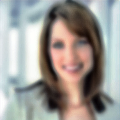

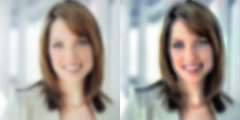

In [27]:
blended_image = cv2.resize(blended_image, (120, 120))
balanced_image = balance_colors(blended_image)

equalized_image = equalize_image(blended_image)

output_image = 0.5*balanced_image + 0.5*equalized_image
cv2_imshow(output_image)


output_image1 = np.concatenate((resized_image, output_image), axis=1)
cv2_imshow(output_image1)


## Metrics For Evaluation

In [32]:
def calculate_image_similarity(image1, image2):
    # Convert images to grayscale if they are in color
    if image1.ndim == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if image2.ndim == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_score = ssim(image1, image2)

    # Calculate PSNR
    psnr_score = psnr(image1, image2)

    # Calculate MSE
    mse_score = np.mean((image1 - image2) ** 2)

    return ssim_score, psnr_score, mse_score

original_image = "/content/drive/My Drive/Domain Adaptation/Del/HD/Final/images.jpeg"
degraded_image = "/content/drive/My Drive/Domain Adaptation/Del/HD/Final/front_face.jpg"


original_image = cv2.imread(original_image)
degraded_image = cv2.imread(degraded_image)


original_image = cv2.resize(original_image, (120, 120))
degraded_image = cv2.resize(degraded_image, (120, 120))

print(calculate_image_similarity(original_image, degraded_image))

(0.6305412938362198, 19.925026886032693, 67.42173611111112)


##Anisotripic Diffusion

In [33]:
import cv2
import numpy as np

# Function to perform Anisotropic Diffusion on a single image
def anisotropic_diffusion(image, iterations=10, kappa=100, gamma=0.02, delta_t=0.1):

    # Convert image to uint8
    image = image.astype(np.uint8)

    # Apply Canny edge detection to compute gradients
    edges = cv2.Canny(image, 50, 150)

    # Invert the edges to get a binary mask for non-edge regions
    edges = 255 - edges

    # Apply diffusion separately to each color channel
    enhanced_image = np.zeros_like(image)
    for i in range(3):
        enhanced_image[:, :, i] = anisotropic_diffusion_single_channel(image[:, :, i], edges, iterations, kappa, gamma, delta_t)

    return enhanced_image

# Function to apply Anisotropic Diffusion to a single-channel image
def anisotropic_diffusion_single_channel(image, edges, iterations=1, kappa=5, gamma=0.02, delta_t=0.1):

    # Convert image to float64
    image = image.astype(np.float64)

    for _ in range(iterations):
        # Calculate gradients using Laplacian filter
        gradient = cv2.Laplacian(image, cv2.CV_64F)

        # Modify the conductance function based on the edges mask
        c = 1 / (1 + edges / kappa)

        # Update image
        image += delta_t * gradient * c

    # Clip values to ensure they are within the range [0, 255] and convert back to uint8
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image



# Process the image and return the enhanced image
enhanced_image = anisotropic_diffusion(output_image)


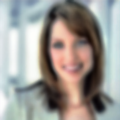

In [34]:
cv2_imshow(enhanced_image)
